# Statistical Power
Julian Hsu
13 April 2023

The purpose of this Jupyter notebook is to discuss and demonstrate the concept of statistical power and how it factors into experimental designs. The key questions we will be answering along the way is:

1. What is the difference between Type 1 and Type 2 Error?
    1. What is statistical Power?
    
2. What are the necessary inputs to calculate statistical power when designing an experiment?
3. What are ways of increasing statistical power?
4. How does statistical power inform my experimental design?
    1. Number of treatments?
    2. How I allocate traffic?
    

In [430]:
from statsmodels.stats.power import TTestIndPower
from scipy import stats
from scipy.stats import norm

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


## What is the difference between Type 1 and Type 2 Error?
### What is statistical Power?

Statistical noise is our data is ever-present and it can never be completely eliminated. Statistical noise is incorporated into these statistical tests and can lead to profound conclusions to whether your tests should be trusted, and how to better design experiments based on them. 

Suppose we have a null hypothesis $H_0$ that we test. We can either conclude that we reject this null hypothesis, or fail to reject it. Rejecting the null hypothesis is usually when we find that an effect is statistically significant, and failing to reject it is that we find the effect is not statistically significant. This conclusion already incorporates a Type 1 error.

**Type 1 error** is the probability that you will reject the null hypothesis when the null hypothesis is actually true. This is also known as a False Positive.

This means that there is a chance your statistical test will draw the wrong conclusion. It doesn't mean that you are using the wrong statistical test, it only means that the data you collected is noisy in such a way that your test drew the wrong conclusion.

You usually hear statistical significant associated with a percentage number, like 10% or 5% statistically significant. These percentages are your False Positive Rates. These correspond to the Type 1 error you are prepared to have. A more accurate way of saying an effect is 5% statistically significant would be, "we reject the null hypothesis and recognize there is a 5% chance we are wrong."

You could also fail to reject the null hypothesis. If you've been reading closely, you'll guess that there is a Type 2 error. And you'd be right. 

**Type 2 error** is the probability that you will fail to reject the null hypothesis when actually the null hypothesis is not true. This is also known as a False Negative.

Again, the culprit is not your statistical test, but simply the data you collected. Type 2 errors means that whenever you fail to reject a null hypothesis, there is a chance that the null hypothesis is actually true. This chance is represented by the False Negative Rate.

**Power** is simply the opposite of the False Negative Rate. Literally, $Power=1-False Negative Rate$. We show below in simulations that there is a balance between the Type 1 and Type 2 error we first determine to do a statistical test. This means that the only way to decrease both Type 1 and Type 2 is collect more data, or otherwise decrease the natural variation in your dataset. More on this in the next section!


We can see how the Type 1 and Type 2 errors are related with the sample below. This sample motivates our theoretical understanding of a power calculation.

Suppose we are designing an experiment, and we estimate an impact of 1.96 standard deviations. All the impact values will be in standard deviations for the remainder of this example. We first want to test whether this impact is statistically different from zero based on our pre-defined False Positive Rate (Type 1 Error). We use a rule of thumb value of 5%. This means we want to test whether this impact is statistically significant at the 95% level. In other words, we have conducted this experiment an infinite number of times, 95% of the time, it would fall in the 95% confidence interval around 1.96. 

Each of these infinite tests would create a single estimate. And we can plot what the distribution of estimates looks like because we have calculcated that the standard error of this estimate is `1`. We can plot the distribution in the first figure below.

Therefore, the 95% confidence interval is `1` times the critical value corresponding to 95% (which coincidentally is 1.96) above and below the estimate. This is the dotted black bracket in the first figure below. Jumping ahead quickly, note that collecting more data causes `1` to shrink and is increasing sample size increases statistical power. 

Now we have a 95% confidence interval that *does not* include zero. But we haven't addressed the chance we make a Type 2 error. A Type 2 error here would be incorrectly failing the reject the null hypothesis. In other words, what are the chances that the 95% confidence interval includes zero? This requires a different approach from before. For the 95% confidence interval, we looked an equal space above and below our estimate at 1.96. But here, we only care that a "given percentage" of our estimates have 95% confidence intervals above zero. This "given percentage" is our statistical power. We use a rule of thumb of 80% statistical power (20% Type 2 Error).

We know from our first figure that once an estimate is below 1.96, the 95% confidence interval includes zero. So we need 80% of our distribution of estimates to be above 1.96. This 80% statistical power corresponds to 0.84. In the second figure, we have drawn the dashed green line by shifting the first distribution up by 0.84. The dotted red line is the smallest estimate with 95% confidence intervals greater than zero (this is 1.96). The area of the distribution to the right of this red line is 80%. 


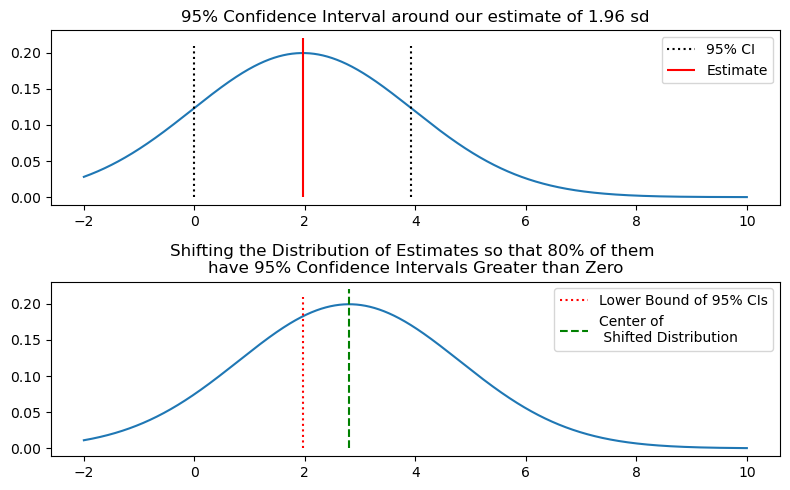

In [462]:
import numpy as np
import matplotlib.pyplot as plt

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-2, 10, 0.001)

fig,ax = plt.subplots(ncols=1,nrows=2, figsize=(8,5))
top=ax[0].plot(x_axis, norm.pdf(x_axis,1.96,2))
ax[0].vlines([0,1.96*2], [0,0], [ax[0].get_ylim()[-1]]*2, color='black', linestyle='dotted', label='95% CI')
ax[0].vlines([1.96], [0], [ax[0].get_ylim()[-1]], color='red', linestyle='solid', label='Estimate')
ax[0].legend()
ax[0].set_title('95% Confidence Interval around our estimate of 1.96 sd')


top=ax[1].plot(x_axis, norm.pdf(x_axis,1.96+0.84,2))
ax[1].vlines([1.96], [0], [ax[1].get_ylim()[-1]], color='red', linestyle='dotted', label='Lower Bound of estimate with 95% CIs above 0')
ax[1].vlines([1.96+0.84], [0], [ax[1].get_ylim()[-1]], color='green', linestyle='dashed', label='Center of \n Shifted Distribution')
ax[1].legend()
ax[1].set_title('Shifting the Distribution of Estimates so that 80% of them \nhave 95% Confidence Intervals Greater than Zero')

plt.tight_layout()
plt.show()

Unlike many prediction problems where we know what the true answer is, we do not have a ground truth of the null hypothesis. This means that we are always at risk of making a Type 1 or Type 2 error.

As stated above, statistical noise is an ever-present thorn in your side when conducting experiments.

How does these concepts show up in practice? Whenever you reject the null hypothesis from an experiment, you need to ask yourself whether this could have been driven by noise rather the actual treatment (Type 1 error). Similarly, whenever you fail to reject the null hypothesis, you need to wonder whether your treatment actually had an effect, but your test thought the effect was noise (Type 2 error). 

Let's see how Type 2 errors can occur in practice. We will simulate multiple experiments where a treatment increases the outcome by 15% on average. With each simulated experiment, we will calculcate statistical tests.

In [35]:
def experimental_simulation_1_treatment(sd=1, nn=200, 
                                        treated_n= 50,
                                        treatment=0.10,
                                       plot=False):
    assert treated_n < nn,'treated_n needs to be less than nn'
    
    sample_df = np.random.normal(0,sd,nn)
    sample_df[0:treated_n] += np.abs(sample_df[0:treated_n])*treatment
    if plot==True:
        fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,3))
        all_x=ax.hist(sample_df[0:treated_n], density=False, color='blue',alpha=0.25, label='Treated')
        treat_x = ax.hist(sample_df[treated_n:], density=False, color='orange',alpha=0.25, label='Control')
        ax.legend()
        fig.show()
    else:
        pass
    ## T-test
    ttest_result=stats.ttest_ind(sample_df[0:treated_n], sample_df[treated_n:])
    ## Record the p-value.
    return ttest_result[1]

In [49]:
'''
We choose a given p-value, and then calculate the average number of times we correctly reject the null hypothesis.
We also calculate the average number of times we incorrectly reject the null hypothesis.

Takeaway is that there is a balance between pvalue and Type 2 Error Rate.
'''
pvalue_list=[]
for s in range(500):
    pv=experimental_simulation_1_treatment(sd=1, nn=100, treated_n=50, treatment=0.15)
    pvalue_list.append(pv)
    
for pv in [0.01, 0.05,0.10, 0.20, 0.30]:
    print('Threshold pvalue={0:5.2f}, Type 2 Error Rate = {1:5.2f}'.format(pv, 
                                                                          len([e for e in pvalue_list if e > pv]) / len(pvalue_list)))

Threshold pvalue= 0.01, Type 2 Error Rate =  0.96
Threshold pvalue= 0.05, Type 2 Error Rate =  0.92
Threshold pvalue= 0.10, Type 2 Error Rate =  0.83
Threshold pvalue= 0.20, Type 2 Error Rate =  0.74
Threshold pvalue= 0.30, Type 2 Error Rate =  0.64


In [48]:
'''
We repeat same exercise as above, but here the true impact is nothing. We calculate whenever we incorrectly fail to
reject the null hypothesis. This should correspond to the exact alpha value we test.
'''
pvalue_list=[]
for s in range(500):
    pv=experimental_simulation_1_treatment(sd=1, nn=100, treated_n=50, treatment=0.0)
    pvalue_list.append(pv)
    
for pv in [0.05,0.10, 0.20]:
    print('Threshold pvalue={0:5.2f}, Type 1 Error Rate = {1:5.2f}'.format(pv, 
                                                                          len([e for e in pvalue_list if e < pv]) / len(pvalue_list)))
    
    
    

Threshold pvalue= 0.05, Type 2 Error Rate =  0.07
Threshold pvalue= 0.10, Type 2 Error Rate =  0.12
Threshold pvalue= 0.20, Type 2 Error Rate =  0.21



## What are the necessary inputs to calculate statistical power when designing an experiment?

The two most popular way statistical power is represented as:
1. How many sample size you need to estimate a specific effect, given a Type 1 and Type 2 error rate;
    1. A similar version of how many more control or treatment needed to estimate a specific effect; and
2. What is the minimum detectable effect (**MDE**) given the number of treated and control?

We are going to look at the formula for calculating statistical power for a continuous outcomes to illustrate how these factors relate to each other. We are basing our formula from [Section 20.3. from here](http://www.stat.columbia.edu/~gelman/stuff_for_blog/chap20.pdf). 

$$ (Z_{\alpha/2} + Z_{\beta/2}) se = \delta $$
where $se= \sqrt{\sigma^2_1 / n_1 + \sigma^2_2 / n_2 }$


There are different ways to represent statistical power because it is a relationship between the following factors:
1. Variation in the outcome among the control group ($\sigma^2_1$),
2. Variation in the outcome among the treated group ($\sigma^2_2$, we usually assume this is the same as control group);
3. Number of treated units ($n_1$);
4. Number of control units ($n_2$);
5. Pre-defined Type 1 error rate ($Z_{\alpha/2}$);
6. Pre-defined Type 2 error rate; and ($Z_{\beta/2}$)
7. The minimum detectable effect size ($Z\delta$).


This looks like a lot of things to take into account! Fortunately, we can combine 1., 2., and 7. Instead of separately tracking the variation in the outcome (1. and 2.) and the effect size (7.), we are going to track the effect size relative to the variation. In other words, we are going to track the standardized minimum detectable effect size. This means that the more variation we have, the smaller the standardized effect is. This logic carries over to percentage lifts as well; the more variation the smaller the percentage list.

Let's visually see how each of these components impact each other.


In [85]:
np.arange(0.20,3.01,0.5)

array([0.2, 0.7, 1.2, 1.7, 2.2, 2.7])

In [385]:
'''
We'll start by generating bunch of data that captures:
3/4. Number of treated units relative to control units;
3/4. The total number of treated and control units; a
5. Predefined Type 1 error rate;
6. Predefined Type2 error rate;
7. Standardized Effect size.
'''
t_n_ratio = [0.05, 0.10, 0.25,0.50]
t_n_total = [20,50,75, 100,150,200, 250, 300]
type1_error_rate = np.arange(0.01,0.80+0.001,0.2)
sd_effect_size = [1/e for e in np.arange(2,20,3)]

df_p = pd.DataFrame()
i=0
for s in sd_effect_size:
    for t_n_r_ in t_n_ratio:
        for t_n_t_ in t_n_total:
            for err1 in type1_error_rate:
                    control_n = int( t_n_r_*t_n_t_ )
                    treat_n = t_n_t_ - control_n
                    pw=TTestIndPower().solve_power(power=None, effect_size = s, 
                                                   nobs1 = control_n,  
                                                   alpha=err1, 
                                                   ratio = t_n_r_)
                    entry_dict= {'sd_size':s, 'total_n': t_n_t_,
                                 'treat_control_ratio': t_n_r_,
                                 'treated_n':treat_n, 'control_n':control_n, 'type1err':err1, 'type2err':1-pw, 'power':pw}
                    df_p = pd.concat([df_p, 
                                      pd.DataFrame(index=[i],data=entry_dict)])
                    i+=1



'\nIn order  to understand the impact over sample size, we need to better understand the interaction of \ntotal sample size and ratio\n'

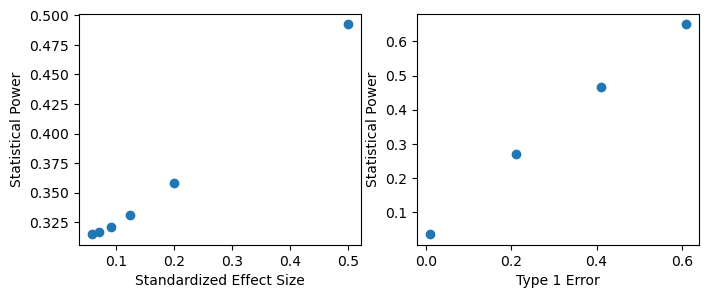

In [386]:
'''
We can only plot in two-dimensions, so let's focus on some key relationships:
A. Statistical power vs effect size
B. Statistical power vs type 1 error rate
'''

fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
sd_pw=df_p.groupby(['sd_size'])['power'].mean()
ax[0].scatter(sd_pw.index, sd_pw.values)
ax[0].set_xlabel('Standardized Effect Size')
ax[0].set_ylabel('Statistical Power')

fpr_pw=df_p.groupby(['type1err'])['power'].mean()
ax[1].scatter(fpr_pw.index, fpr_pw.values)
ax[1].set_xlabel('Type 1 Error')
ax[1].set_ylabel('Statistical Power')

'''
In order  to understand the impact over sample size, we need to better understand the interaction of 
total sample size and ratio
'''


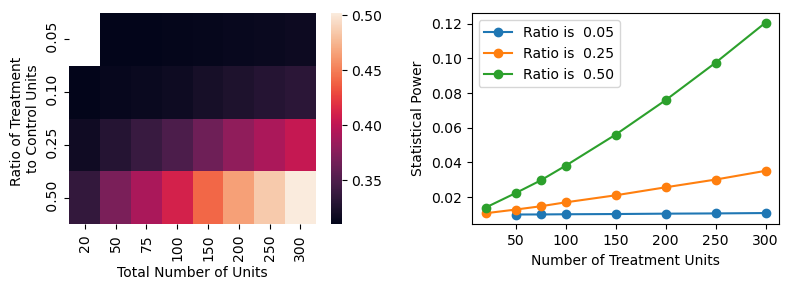

In [387]:
all_ratios = df_p['treat_control_ratio'].unique().tolist()


fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,3))
g=sns.heatmap(pd.pivot_table(df_p, 
        columns=['total_n'], 
        index=['treat_control_ratio'], 
        values=['power'], 
        aggfunc='mean'),ax=ax[0] )
ax[0].set_xlabel('Total Number of Units')
ax[0].set_ylabel('Ratio of Treatment \nto Control Units')
ax[0].set_yticklabels(['{0:5.2f}'.format(e) for e in all_ratios])
ax[0].set_xticklabels([str(e) for e in t_n_total])



sd=df_p.loc[(df_p['treat_control_ratio']==all_ratios[0])&(df_p['type1err']==0.01)  & (df_p['sd_size']==0.2) ]
ax[1].plot(sd['total_n'], sd['power'], marker='o', label='Ratio is {0:5.2f}'.format(t_n_ratio[0]))


sd=df_p.loc[(df_p['treat_control_ratio']==all_ratios[2])&(df_p['type1err']==0.01)  & (df_p['sd_size']==0.2) ]
ax[1].plot(sd['total_n'], sd['power'], marker='o', label='Ratio is {0:5.2f}'.format(t_n_ratio[2]))

sd=df_p.loc[(df_p['treat_control_ratio']==all_ratios[-1])&(df_p['type1err']==0.01)  & (df_p['sd_size']==0.2) ]
ax[1].plot(sd['total_n'], sd['power'], marker='o', label='Ratio is {0:5.2f}'.format(t_n_ratio[-1]))

ax[1].set_ylabel('Statistical Power')
ax[1].set_xlabel('Number of Treatment Units')
ax[1].legend()
fig.tight_layout()


__**Takeaways**__

1. The larger the minimum effect size (which is equivalent to a smaller variance, or larger level or percentage outcome), the larger the statistical power;
2. There is a direct relationship between statistical power and making a Type 1 error. This is the same as what we found before that there is a trade-off betwen making a Type 1 vs Type 2 error;
3. As the sample size increases, holding the proportion of treatment/control units constant, the statistical power increases;
4. When we cannot increase the sample size, statistical power is maximized when the number of treated units is the same as the number of control units.

## What are ways of increasing statistical power?

Based on the above, we can increase statistical power by:
1. **Increase the standardized effect size**
    1. **Increase the expected effect size**: if we believe our treatment is going to have a larger effect, then we will immediately increase our statistical power. Note that over-estimating the effect size risks running an experiment that is underpowered.
    2. **Decrease the variance**: There are several strategies we can use to do this, that go outside of the scope of these notes. (a) sample stratification and (b) further causal modeling.
2. **Increasing our Type 1 error rate.** However, we would allow for our hypothesis test to be more likely to be a False Positive. That is, there is a greater chance that our fail to reject the null hypothesis when in fact the null hypothesis is true. 
3. **Have the same number of treatment and control units.** Unlike those discussed above, the benefit of doing this has an upper limit. Once the number of treated and control units differ, the statistical power will go down;
4. **Increase your sample size.** This is a popular option, given that it comes at no additional risk to an under powered experiment (1), no scientific sacrifice (2), and has no upper limit (3). We also found above that the returns to increasing sample size diminish over time. That is, an experiment benefit more from having the 5th sample than the 500th sample.


## How does statistical power inform my experimental design?
### Number of treatments?
We may be interested in multiple treatments. This requires us to divide our sample into multiple treatment arms. For example, we can divide the sample into one control group, one treatment group, and a second treatment group. Let's put aside the issue of comparing treatments for simplicity and focus on comparing each of the treatment groups to the control. This means we are now doing two comparisons, where each has their own statistical power. This mechanically decreases statistical power because there are more treatments to allocate to.

If you split the sample among all treatments, then you will halve your statistical power when you introduce your second treatment, divide your power by three when you introduce your third treatment, etc.

But what if you could allocate different units to the treatments? This can be an option depending on your set up. We will show how one experiment can have different treatment arms. 


### How I allocate traffic?

In [424]:
'''
The objective is to show how given a sample size, increasing the number of treatment arms will decrease the MDE.
'''

'''
The objective is to show, for a given sample size, the relationship between statistical power and MDE.
We want to show how this deteriorates as we have more treatment arms.
'''

t_n_total=[4000,8000]
num_treatments=[1,2,3,4]
prop_list = [0.10,0.30]

i=0
df_mt=pd.DataFrame()
for t_n_t_ in t_n_total:
    for nt in num_treatments:
        for prop in prop_list:
            ## Based on the number of treatments, calculate the MDE
            ## given the proportion of observations on treatment
#             prop=0.10

            treatment_n = t_n_t_*prop
            control_n = t_n_t_*(1-nt*prop)
            if control_n < 0:
                pass
            else:
                ## recall that total sample size is nobs1*(1+ratio)
                mde=TTestIndPower().solve_power(power=0.80, alpha=0.05, 
                                               effect_size = None, 
                                               nobs1 = treatment_n,
                                                ratio = -1+(treatment_n+control_n)/treatment_n )
                entry_dict= {'total_n': t_n_t_,
                             'control_n':control_n,
                             'treatment_n':treatment_n,
                             'num_treatments':nt,
                             'proportion_treat':prop,
                             'mde':mde,
                             'power':0.80}
                df_mt = pd.concat([df_mt, pd.DataFrame(index=[i],data=entry_dict)])


                i+=1


Text(0, 0.5, 'MDE')

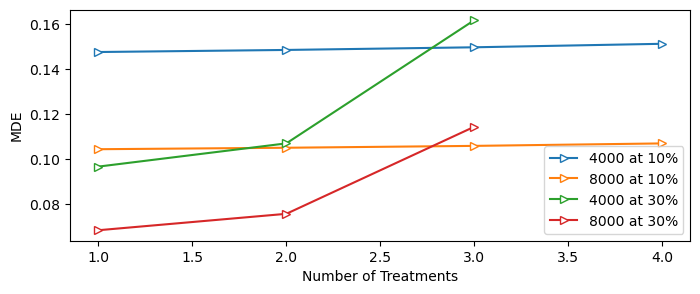

In [429]:
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(8,3))
for p in df_mt['proportion_treat'].unique():
    for nn in df_mt['total_n'].unique():
        plot_ = df_mt.loc[(df_mt['total_n']==nn)
                         &(df_mt['proportion_treat']==p)]
        ax.plot(plot_['num_treatments'], plot_['mde'], 
                marker='>',
                markerfacecolor='white',
                label='{0:2.0f} at {1:2.0f}%'.format(nn,p*100))
ax.legend()
ax.set_xlabel('Number of Treatments')
ax.set_ylabel('MDE')

**Takeaway**
Increasing the number of treatment arms has an immediate impact on your statistical power based on the minimum detectable effect size (MDE). While the statistical power will diminish (measured by an increase in MDE) as you increas the number of treatment, unless you have dedicated a large portion of your sample to treatment, there are little changes.

In [ ]:
break

In [360]:
'''
The objective is to show, for a given sample size, the relationship between statistical power and MDE.
We want to show how this deteriorates as we have more treatment arms.
'''

t_n_total=[150,450]
sd_effect_size = [1/e for e in np.arange(5,31,4)]
num_treatments=[1,2]
treatment_allocations=[0.02, 0.05, 0.10,0.15, 0.20]

i=0
df_mt=pd.DataFrame()
for s in sd_effect_size:
    for t_n_t_ in t_n_total:
        for nt in num_treatments:
            for ta in treatment_allocations:
                ## Based on the number of treatments, calculcate the control size.
                ## Assume all treatment arms are the same size
                control = t_n_t_ *(1- nt*ta)
                treatment1 = t_n_t_ *ta
                
                
                pw=TTestIndPower().solve_power(power=None, alpha=0.05, 
                                               effect_size = s, 
                                               nobs1 = treatment1+control,  ratio =  control/treatment1 )
                entry_dict= {'sd_size':s, 'total_n': t_n_t_,
                             'control_n':control,
                             'num_treatments':nt,
                             'ratio':treatment1/control,
                             'treatment_n':treatment1, 'treatment':1,
                             'treatment_sample_of_total':treatment1/t_n_t_,
                             'type2err':1-pw, 'power':pw}
                df_mt = pd.concat([df_mt, pd.DataFrame(index=[i],data=entry_dict)])


                i+=1

df_mt['treatment_control_ratio'] = df_mt['treatment_n'] / df_mt['control_n']

Text(0.5, 1.0, '')

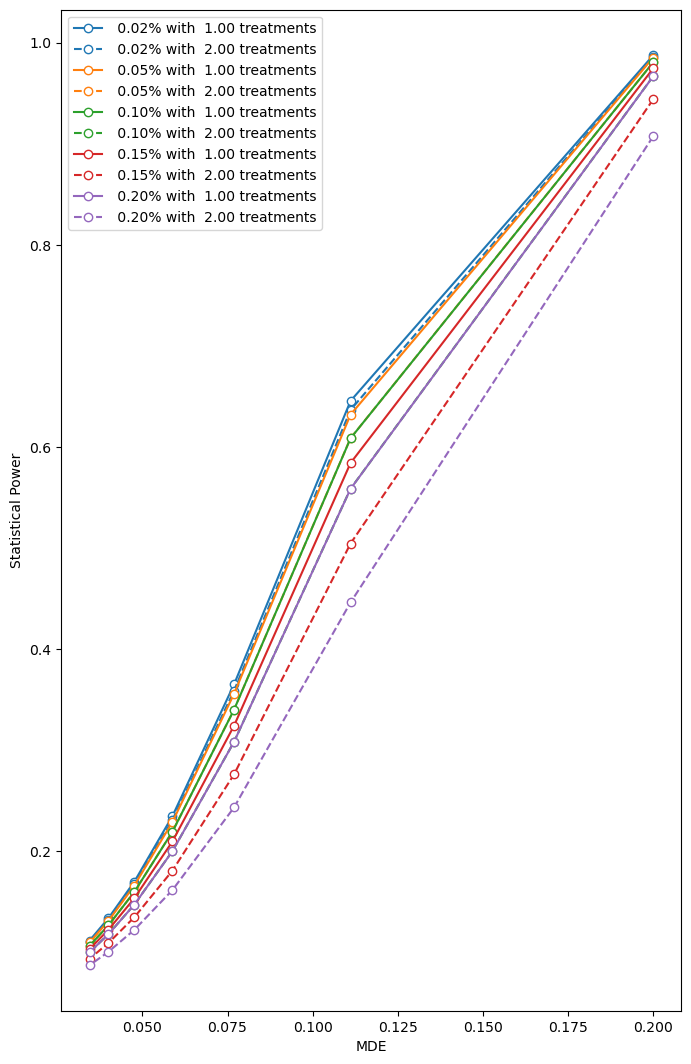

In [362]:
'''
We want to plot the relationship between effect size and statistical power.
For a given experiment, do a separate plot for the two treatment and controls.
Each figure should be for a given sample size.
'''
plot_ = df_mt.loc[df_mt['total_n']==450]
plot_.reset_index(inplace=True)

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(8,13))
tcr=plot_['num_treatments'].sort_values().unique()
for tp in plot_['treatment_sample_of_total'].unique():
    i=0
    for tcr_ in tcr:
        if i==0:
            aei=ax.plot(plot_.loc[(plot_['treatment_sample_of_total']==tp) & (plot_['num_treatments']==tcr_)]['sd_size'], 
                plot_.loc[(plot_['treatment_sample_of_total']==tp) & (plot_['num_treatments']==tcr_)]['power'], 
                        marker='o', markerfacecolor='white', label='{1:5.2f}% with {0:5.2f} treatments'.format(tcr_,tp))            
        else:
            ax.plot(plot_.loc[(plot_['treatment_sample_of_total']==tp) & (plot_['num_treatments']==tcr_)]['sd_size'], 
                plot_.loc[(plot_['treatment_sample_of_total']==tp) & (plot_['num_treatments']==tcr_)]['power'], 
                    color =aei[0].get_color() ,
                    linestyle='dashed',
                    marker='o', markerfacecolor='white', label='{1:5.2f}% with {0:5.2f} treatments'.format(tcr_,tp))            
        i+=1
ax.legend()
ax.set_xlabel('MDE')
ax.set_ylabel('Statistical Power')
ax.set_title('')